In [1]:
# Notebook setup (segment pipeline) / Notebook 初始化（segment 管线）
import os
from pathlib import Path
import sqlite3
import sys
import pandas as pd

def _find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

try:
    from airline_revenue_analytics.config import get_paths
except ModuleNotFoundError:
    # Fall back to src/ on sys.path for notebook runs.
    repo_root = _find_repo_root(Path.cwd())
    src_root = repo_root / "src"
    if str(src_root) not in sys.path:
        sys.path.append(str(src_root))
    try:
        from airline_revenue_analytics.config import get_paths
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("Install the package first: pip install -e .") from exc

# Resolve repo paths and DB location / 解析仓库路径与数据库位置
paths = get_paths("segment")
REPO_ROOT = paths.repo_root
DATA_DIR = paths.data_raw
OUT_DIR = paths.outputs_root
FIG_DIR = paths.figures
TAB_DIR = paths.tables
ART_DIR = paths.artifacts
DB_PATH = paths.db_path
db_path = DB_PATH

# SQLite connection (shared across cells) / SQLite 连接（全局复用）
conn = sqlite3.connect(DB_PATH)

def _rel(p: Path) -> str:
    """Render repo-relative paths for display / 将路径显示为仓库相对路径."""
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return str(p)

def find_path(filename: str) -> Path:
    """Locate a file under outputs/ or data/raw / 在 outputs/ 或 data/raw 中定位文件."""
    for p in (OUT_DIR / filename, DATA_DIR / filename, REPO_ROOT / filename):
        if p.exists():
            return p
    for root, _, files in os.walk(OUT_DIR):
        if filename in files:
            return Path(root) / filename
    raise FileNotFoundError(
        f"Cannot find {filename}. Put it under data/raw or outputs/segment."
    )


In [2]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


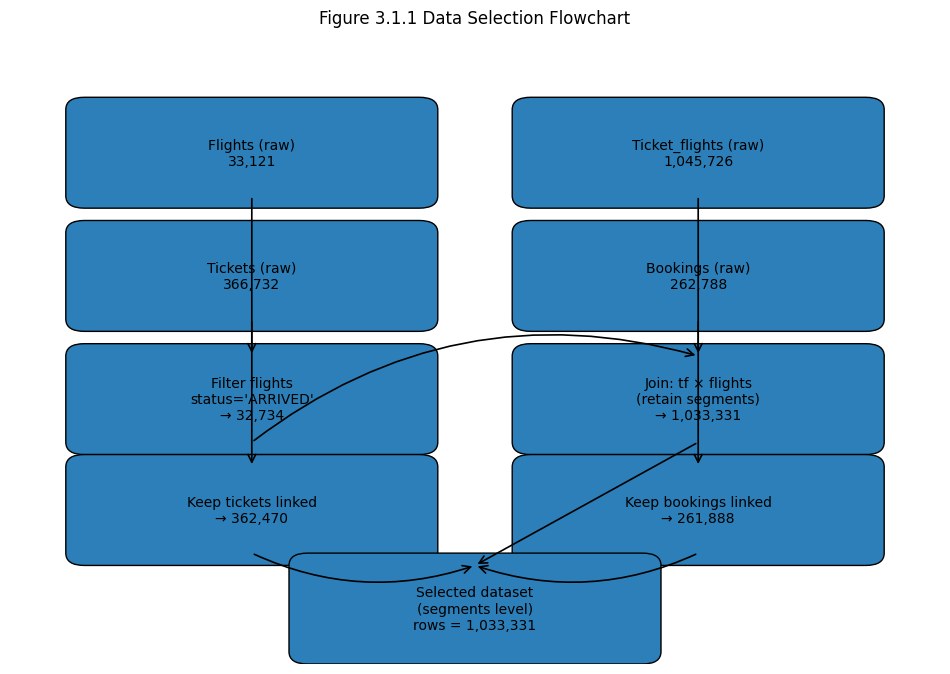

Saved PNG: /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_1_1_selection_flow.png


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from pathlib import Path
import os

FIG_DIR.mkdir(parents=True, exist_ok=True)

before = {'flights': 33121, 'ticket_flights': 1045726, 'tickets': 366732, 'bookings': 262788}
after = {'flights': 32734, 'ticket_flights': 1033331, 'tickets': 362470, 'bookings': 261888}


plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_axis_off()

def box(x,y,w,h,text):
    rect = FancyBboxPatch((x,y), w,h, boxstyle="round,pad=0.02,rounding_size=0.02", linewidth=1)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, text, ha='center', va='center')
    return (x,y,w,h)

# -- Use the before/after numbers calculated in the previous section / -- 使用上一节计算的前后对比数值
f_raw, tf_raw, t_raw, b_raw = before['flights'], before['ticket_flights'], before['tickets'], before['bookings']
f_sel, tf_sel, t_sel, b_sel = after['flights'], after['ticket_flights'], after['tickets'], after['bookings']

# -- Positioning / -- 布局定位
raw_f  = box(0.08, 0.76, 0.36, 0.14, f"Flights (raw)\n{f_raw:,}")
raw_tf = box(0.56, 0.76, 0.36, 0.14, f"Ticket_flights (raw)\n{tf_raw:,}")
raw_t  = box(0.08, 0.56, 0.36, 0.14, f"Tickets (raw)\n{t_raw:,}")
raw_b  = box(0.56, 0.56, 0.36, 0.14, f"Bookings (raw)\n{b_raw:,}")

step1  = box(0.08, 0.36, 0.36, 0.14, f"Filter flights\nstatus='ARRIVED'\n→ {f_sel:,}")
step2  = box(0.56, 0.36, 0.36, 0.14, f"Join: tf × flights\n(retain segments)\n→ {tf_sel:,}")
step3  = box(0.08, 0.18, 0.36, 0.14, f"Keep tickets linked\n→ {t_sel:,}")
step4  = box(0.56, 0.18, 0.36, 0.14, f"Keep bookings linked\n→ {b_sel:,}")
final  = box(0.32, 0.02, 0.36, 0.14, f"Selected dataset\n(segments level)\nrows = {tf_sel:,}")

def connect(p1, p2, rad=0.0):
    x1,y1,w1,h1 = p1
    x2,y2,w2,h2 = p2
    start = (x1+w1/2, y1)      # bottom center
    end   = (x2+w2/2, y2+h2)   # top center
    ax.add_patch(FancyArrowPatch(start, end, arrowstyle='->',
                                 mutation_scale=14, linewidth=1.2,
                                 connectionstyle=f"arc3,rad={rad}"))

# Direct vertical connections / 直接垂直连接
connect(raw_f, step1, 0.0)
connect(raw_tf, step2, 0.0)
connect(raw_t, step3, 0.0)
connect(raw_b, step4, 0.0)
# Use arcs for cross-connections to avoid overlap / 交叉连接用弧线避免重叠
connect(step1, step2, rad=-0.25)
connect(step2, final, rad=0.0)
connect(step3, final, rad=0.20)
connect(step4, final, rad=-0.20)

plt.title("Figure 3.1.1 Data Selection Flowchart", pad=18)
out = FIG_DIR/"figure_3_1_1_selection_flow.png"
fig.savefig(out, dpi=300, bbox_inches='tight'); plt.show()
print("Saved PNG:", out)

In [4]:
import os, numpy as np, pandas as pd
from IPython.display import display

# Ensure segment-level feature table is available for downstream cells / 确保航段级特征表可用于下游单元
if "seg" not in globals():
    X_path = find_path("X_features.parquet")
    y_path = find_path("y_target.parquet")
    seg = pd.read_parquet(X_path)
    y_seg = pd.read_parquet(y_path).squeeze()
    seg["amount"] = y_seg.values


# Column aliasing: keep TitleCase names even if X_features uses snake_case
_alias_map = {
    "Sched_Flight_Duration_Minutes": "sched_flight_duration_minutes",
    "Booking_Lead_Time_Days": "booking_lead_time_days",
    "Fare_Class": "fare_conditions",
    "Fare_Class_Ordinal": "cabin_index",
    "Is_Premium_Cabin": "is_premium_cabin",
    "Departure_DOW": "day_of_week",
    "Departure_Hour": "hour_of_day",
    "Is_Weekend": "is_weekend",
    "Route_Code": "route_code",
    "Aircraft_Model_EN": "aircraft_model_en",
    "Seats_Per_Aircraft": "seats_per_aircraft",
    "Is_LongHaul": "is_longhaul",
    "Is_Widebody": "is_widebody",
}
for primary, alt in _alias_map.items():
    if primary not in seg.columns and alt in seg.columns:
        seg[primary] = seg[alt]
# Defaults if not defined earlier / 若未提前定义则使用默认值
SEAT_THRESHOLD = globals().get("SEAT_THRESHOLD", 240)
WIDEBODY_KEYWORDS = globals().get("WIDEBODY_KEYWORDS", ["777","787","747","767","a330","a340","a350","a380","il-96"])

# Derive Is_Weekend when day-of-week is available
if "Is_Weekend" not in seg.columns and "Departure_DOW" in seg.columns:
    seg["Is_Weekend"] = seg["Departure_DOW"].isin([5, 6]).astype("Int8")
# Derive missing flags for reporting-only checks
if "Is_LongHaul" not in seg.columns and "Sched_Flight_Duration_Minutes" in seg.columns:
    seg["Is_LongHaul"] = (seg["Sched_Flight_Duration_Minutes"] >= 240).astype("Int8")
if "Is_Widebody" not in seg.columns:
    _widebody = None
    if "Seats_Per_Aircraft" in seg.columns:
        _widebody = seg["Seats_Per_Aircraft"].astype(float) >= SEAT_THRESHOLD
    if "Aircraft_Model_EN" in seg.columns:
        _kw = [k.lower() for k in WIDEBODY_KEYWORDS]
        _model_flag = (
            seg["Aircraft_Model_EN"].astype(str).str.lower()
            .apply(lambda s: any(k in s for k in _kw))
        )
        _widebody = _model_flag if _widebody is None else (_widebody | _model_flag)
    if _widebody is not None:
        seg["Is_Widebody"] = _widebody.astype("Int8")


def show_table(df: pd.DataFrame, title: str, csv_filename: str,
               thousands_cols=None, percent_cols=None, hide_index=True):
    thousands_cols = thousands_cols or []
    percent_cols   = percent_cols or []
    t = df.copy()
    for c in thousands_cols:
        if c in t.columns:
            t[c] = t[c].map(lambda x: f"{int(x):,}" if pd.notna(x) else "")
    for c in percent_cols:
        if c in t.columns:
            t[c] = t[c].map(lambda v: f"{v:.1f}%" if pd.notna(v) else "")
    out_csv = TAB_DIR/csv_filename
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV -> {out_csv}")
    try:
        sty = (t.style
               .set_table_styles([{'selector':'th','props':'font-weight:bold; text-align:center;'},
                                  {'selector':'td','props':'text-align:center;'}])
               .set_properties(**{'text-align':'center'}))
        if hasattr(sty, "hide_index"):
            sty = sty.hide_index()
        else:
            sty = sty.hide(axis="index")
        print(title)
        display(sty)
    except Exception:
        display(t)

feature_dict = [
 # Name, definition/rule, type, granularity, business motivation / 名称, 定义/规则, 类型, 分析粒度, 业务动机
 ["Route_Code",
  "Concatenate departure_airport and arrival_airport (e.g., DME-KHV).",
  "string","segment (ticket_flight × flight)",
  "Capture route-level effects for pricing and revenue."],

 ["Sched_Flight_Duration_Minutes",
  "UTC(scheduled_arrival) − UTC(scheduled_departure) in minutes; negatives set to NaN.",
  "float","segment",
  "Proxy for distance/service level; strong price driver."],

 ["Booking_Lead_Time_Days",
  "UTC(dep) − UTC(book_date) in days; negatives set to NaN per 3.2 policy.",
  "float","segment",
  "Captures demand timing and the early-bird premium phenomenon."],

 ["Departure_DOW","Day of week of UTC(dep) [0=Mon].","int","segment",
  "Weekly patterns without requiring long-span seasonality."],

 ["Departure_Hour","Hour of day of UTC(dep) [0–23].","int","segment",
  "Intra-day pricing and operational patterns."],

 ["Is_Weekend","1 if DOW ∈ {Sat,Sun}, else 0.","int (0/1)","segment",
  "Captures leisure/business mix by calendar."],

 ["Fare_Class","Cleaned fare_conditions ∈ {Economy, Comfort, Business}.",
  "category","segment","Primary driver of per-segment price."],

 ["Fare_Class_Ordinal","Map Economy=0, Comfort=1, Business=2.","int","segment",
  "Order-aware representation for linear models."],

 ["Is_Premium_Cabin","1 if Fare_Class ∈ {Comfort,Business}, else 0.",
  "int (0/1)","segment","Binary simplification for rule cards and trees."],

 ["Aircraft_Model_EN","English label parsed from JSON model.","string","segment",
  "Human-readable aircraft feature for interpretation."],

 ["Seats_Per_Aircraft","Count seats per aircraft_code from seats table.",
  "int","segment","Capacity proxy; helps explain cabin mix & price."],

 ["Is_Widebody",
  f"1 if Seats_Per_Aircraft ≥ {SEAT_THRESHOLD} OR Aircraft_Model_EN contains any of {WIDEBODY_KEYWORDS}.",
  "int (0/1)","segment","Flag widebody operations affecting price & perception."],

 ["Is_LongHaul","1 if Sched_Flight_Duration_Minutes ≥ 240, else 0.",
  "int (0/1)","segment","Separates long vs short haul for pattern search."]
]

tbl_331 = pd.DataFrame(feature_dict, columns=[
    "Feature Name","Definition / Rule","Data Type","Analytical Grain","Rationale"
])
show_table(tbl_331, "Table 3.3.1 – Feature Dictionary",
           "table_3_3_1_feature_dictionary.csv")


Saved CSV -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/tables/table_3_3_1_feature_dictionary.csv
Table 3.3.1 – Feature Dictionary


Feature Name,Definition / Rule,Data Type,Analytical Grain,Rationale
Route_Code,"Concatenate departure_airport and arrival_airport (e.g., DME-KHV).",string,segment (ticket_flight × flight),Capture route-level effects for pricing and revenue.
Sched_Flight_Duration_Minutes,UTC(scheduled_arrival) − UTC(scheduled_departure) in minutes; negatives set to NaN.,float,segment,Proxy for distance/service level; strong price driver.
Booking_Lead_Time_Days,UTC(dep) − UTC(book_date) in days; negatives set to NaN per 3.2 policy.,float,segment,Captures demand timing and the early-bird premium phenomenon.
Departure_DOW,Day of week of UTC(dep) [0=Mon].,int,segment,Weekly patterns without requiring long-span seasonality.
Departure_Hour,Hour of day of UTC(dep) [0–23].,int,segment,Intra-day pricing and operational patterns.
Is_Weekend,"1 if DOW ∈ {Sat,Sun}, else 0.",int (0/1),segment,Captures leisure/business mix by calendar.
Fare_Class,"Cleaned fare_conditions ∈ {Economy, Comfort, Business}.",category,segment,Primary driver of per-segment price.
Fare_Class_Ordinal,"Map Economy=0, Comfort=1, Business=2.",int,segment,Order-aware representation for linear models.
Is_Premium_Cabin,"1 if Fare_Class ∈ {Comfort,Business}, else 0.",int (0/1),segment,Binary simplification for rule cards and trees.
Aircraft_Model_EN,English label parsed from JSON model.,string,segment,Human-readable aircraft feature for interpretation.


In [5]:
# Type checks / 类型检查
def _col(name):
    return seg[name] if name in seg.columns else None

def _is_numeric(col):
    if col is None:
        return "missing"
    s = col.dropna()
    return isinstance(s.iloc[0], (int, float, np.floating)) if len(s) else True

def _is_binary(col):
    if col is None:
        return "missing"
    s = col.dropna()
    return s.isin([0, 1]).all()

print("Type Check:",
      _is_numeric(_col("Sched_Flight_Duration_Minutes")),
      _is_numeric(_col("Booking_Lead_Time_Days")),
      _is_binary(_col("Is_Premium_Cabin")),
      _is_binary(_col("Is_Widebody")))

# Range checks / 取值范围检查
if "Sched_Flight_Duration_Minutes" in seg.columns:
    neg_dur = int((seg["Sched_Flight_Duration_Minutes"] < 0).sum(skipna=True))
else:
    neg_dur = "missing"
if "Booking_Lead_Time_Days" in seg.columns:
    neg_lead = int((seg["Booking_Lead_Time_Days"] < 0).sum(skipna=True))
else:
    neg_lead = "missing"
print(f"Range Check: negatives – duration={neg_dur}, lead_time={neg_lead} (expected 0 after cleaning)")

# Logic check: premium cabin 比例 ≈ Business/Comfort 占比
if "Is_Premium_Cabin" in seg.columns and "Fare_Class" in seg.columns:
    p1 = seg["Is_Premium_Cabin"].mean()
    p2 = seg["Fare_Class"].isin(["Business", "Comfort"]).mean()
    print(f"Logic Check: Is_Premium_Cabin share = {p1:.4f} | "
          f"share(Business/Comfort) = {p2:.4f} | Δ={abs(p1-p2):.6f} (expect ~0)")
else:
    print("Logic Check: skipped (missing Is_Premium_Cabin or Fare_Class)")


Type Check: True True True True
Range Check: negatives – duration=0, lead_time=0 (expected 0 after cleaning)
Logic Check: Is_Premium_Cabin share = 0.1196 | share(Business/Comfort) = 0.1196 | Δ=0.000000 (expect ~0)


Preview: missing columns -> ['ticket_no', 'Seats_Per_Aircraft']


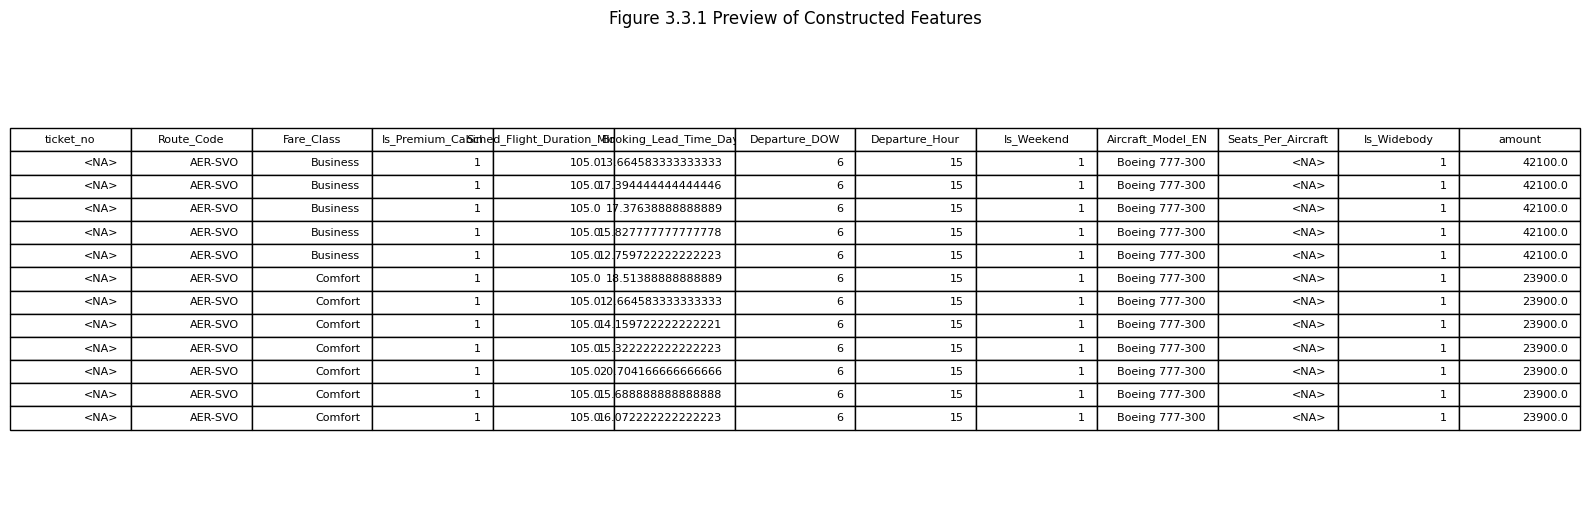

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_3_1_feature_preview.png


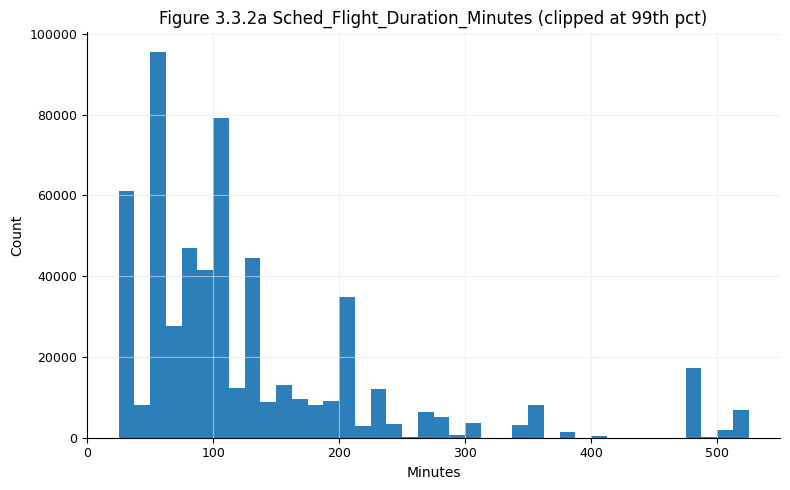

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_3_2a_duration_hist.png


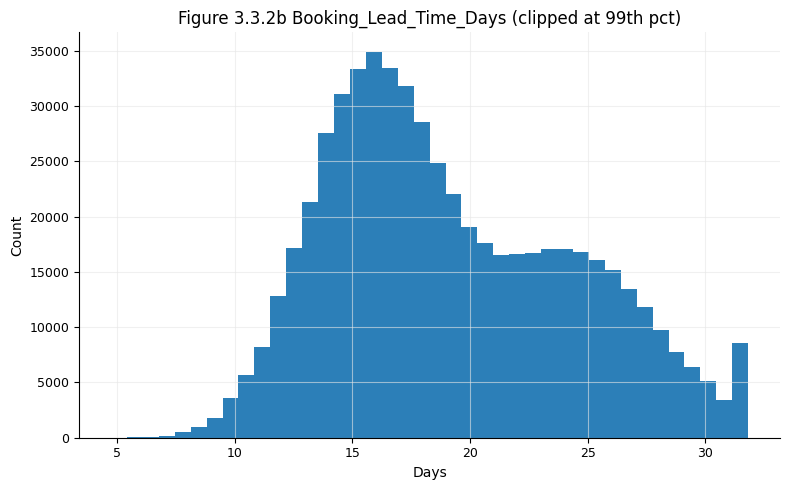

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_3_2b_leadtime_hist.png


In [6]:
plt.close('all')
preview_cols = ['ticket_no','Route_Code','Fare_Class','Is_Premium_Cabin',
                'Sched_Flight_Duration_Minutes','Booking_Lead_Time_Days',
                'Departure_DOW','Departure_Hour','Is_Weekend',
                'Aircraft_Model_EN','Seats_Per_Aircraft','Is_Widebody','amount']
missing_cols = [c for c in preview_cols if c not in seg.columns]
if missing_cols:
    print('Preview: missing columns ->', missing_cols)
preview_df = seg[[c for c in preview_cols if c in seg.columns]].head(12).copy()
for c in missing_cols:
    preview_df[c] = pd.NA
preview_df = preview_df[preview_cols]

fig_h = 1.2 + 0.35*len(preview_df)
fig, ax = plt.subplots(figsize=(16, fig_h))
ax.axis('off')
tbl = ax.table(cellText=preview_df.values,
               colLabels=preview_df.columns, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)
plt.title("Figure 3.3.1 Preview of Constructed Features", pad=10)
plt.tight_layout()
png1 = FIG_DIR/"figure_3_3_1_feature_preview.png"
plt.savefig(png1, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", png1)

# A) Flight duration (minutes) / A）飞行时长（分钟）
dur = seg['Sched_Flight_Duration_Minutes'].astype(float)
q99 = np.nanpercentile(dur, 99) if dur.notna().any() else 0
dur_clip = dur.clip(upper=q99)

plt.figure(figsize=(8,5))
plt.hist(dur_clip.dropna(), bins=40)
plt.title("Figure 3.3.2a Sched_Flight_Duration_Minutes (clipped at 99th pct)")
plt.xlabel("Minutes"); plt.ylabel("Count")
plt.tight_layout()
png2a = FIG_DIR/"figure_3_3_2a_duration_hist.png"
plt.savefig(png2a, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", png2a)

# B) Booking lead time (days) / B）订票提前期（天）
lead = seg['Booking_Lead_Time_Days'].astype(float)
q99b = np.nanpercentile(lead, 99) if lead.notna().any() else 0
lead_clip = lead.clip(lower=0, upper=q99b)

plt.figure(figsize=(8,5))
plt.hist(lead_clip.dropna(), bins=40)
plt.title("Figure 3.3.2b Booking_Lead_Time_Days (clipped at 99th pct)")
plt.xlabel("Days"); plt.ylabel("Count")
plt.tight_layout()
png2b = FIG_DIR/"figure_3_3_2b_leadtime_hist.png"
plt.savefig(png2b, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", png2b)


Lookup coverage → aircrafts_data: 100.0% | dep-airport: 100.0% | arr-airport: 100.0%


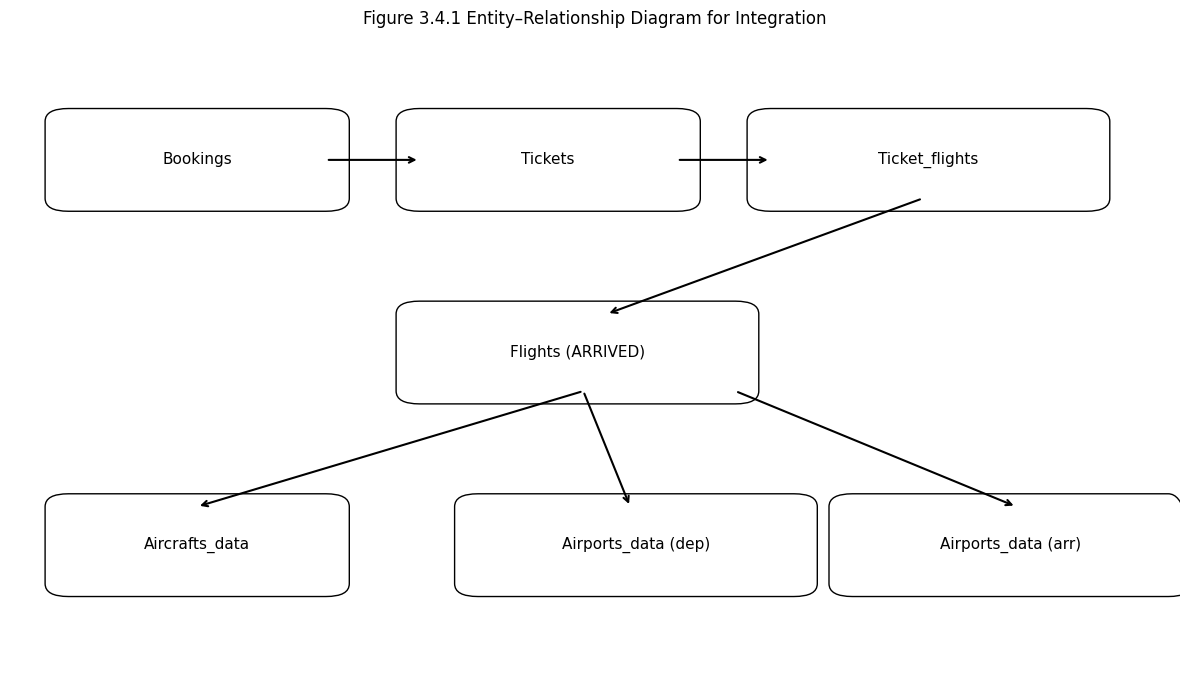

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_4_1_ER.png
Saved CSV -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/tables/table_3_4_1_integration_steps.csv
Table 3.4.1 – Integration Step Row Counts


Step,Rows,Cols
ticket_flights (raw),1045726,4
flights (ARRIVED only),16707,8
join1: tf × flights (inner),574830,11
join2: + tickets (inner),574830,12
join3: + bookings (inner),574830,14
join4: + aircrafts_data (left),574830,16
"join5: + airports_data (dep,left)",574830,19
"join6: + airports_data (arr,left)",574830,22


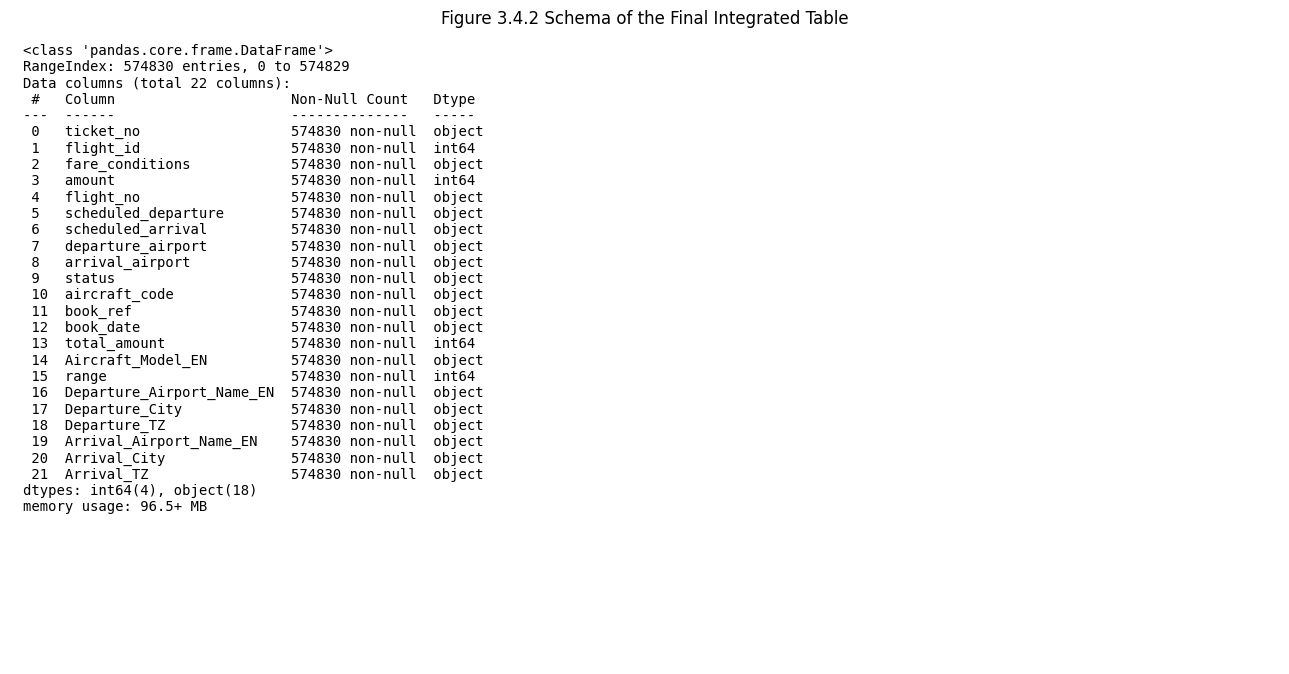

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_4_2_schema.png

— Validation summary —
Rows(tf raw) = 1,045,726 | Rows(flights raw) = 33,121 | Rows(ARRIVED) = 16,707
Rows after tf×flights = 574,830 | final_df rows = 574,830
Primary key (ticket_no, flight_id) unique? True
Lookup coverage: aircraft_model_en=100.0%, dep_airport_name_en=100.0%, arr_airport_name_en=100.0%


In [7]:
import os, json, sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import matplotlib.patches as patches

TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

try:
    conn
except NameError:
    import glob
    cands = glob.glob(str(DATA_DIR / "*.sqlite"))+glob.glob(str(DATA_DIR / "*.db"))+glob.glob(str(DATA_DIR / "*.sqlite3"))
    if not cands:
        raise FileNotFoundError("No SQLite found under data/. Please place airlines_db.sqlite there.")

def to_utc(x): return pd.to_datetime(x, errors='coerce', utc=True)

def get_json_en(sr: pd.Series):
    def _x(s):
        if pd.isna(s) or s == '\\N': return pd.NA
        try: return json.loads(s).get('en', pd.NA)
        except Exception: return pd.NA
    return sr.apply(_x)

def show_table(df: pd.DataFrame, title: str, csv_filename: str):
    out_csv = TAB_DIR/csv_filename
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV -> {out_csv}")
    t = df.copy()
    try:
        sty = (t.style
               .set_table_styles([{'selector':'th','props':'font-weight:bold; text-align:center;'},
                                  {'selector':'td','props':'text-align:center;'}])
               .set_properties(**{'text-align':'center'}))
        # 兼容不同 Pandas 版本
        if hasattr(sty, "hide_index"):
            sty = sty.hide_index()
        else:
            sty = sty.hide(axis="index")
        print(title)
        display(sty)
    except Exception:
        print(title)
        display(t)

# 1) Load raw tables / 1）加载原始表
tf = pd.read_sql("SELECT ticket_no, flight_id, fare_conditions, amount FROM ticket_flights;", conn)
t  = pd.read_sql("SELECT ticket_no, book_ref FROM tickets;", conn)
b  = pd.read_sql("SELECT book_ref, book_date, total_amount FROM bookings;", conn)
fl = pd.read_sql("""
    SELECT flight_id, flight_no, scheduled_departure, scheduled_arrival,
           departure_airport, arrival_airport, status, aircraft_code
    FROM flights;
""", conn)
ac = pd.read_sql("SELECT aircraft_code, model, range FROM aircrafts_data;", conn)
ap = pd.read_sql("SELECT airport_code, airport_name, city, timezone FROM airports_data;", conn)

# before counts / 清洗前计数
n_tf_raw = len(tf); n_fl_raw = len(fl); n_t_raw = len(t); n_b_raw = len(b)

# keep arrived flights / 仅保留已到达航班
fl_arr = fl.loc[fl['status'].str.upper()=='ARRIVED'].copy()
n_fl_arr = len(fl_arr)

# 2) Core joins (inner) with validation / 2）核心连接（内连接）与校验
step_log = []

step_log.append(["ticket_flights (raw)", n_tf_raw, tf.shape[1]])
step_log.append(["flights (ARRIVED only)", n_fl_arr, fl_arr.shape[1]])

# tf × flights (inner) many_to_one / tf × flights（内连接）多对一
j1 = tf.merge(fl_arr, on='flight_id', how='inner', validate='many_to_one')
step_log.append(["join1: tf × flights (inner)", len(j1), j1.shape[1]])

# + tickets (inner) many_to_one / + tickets（内连接）多对一
j2 = j1.merge(t, on='ticket_no', how='inner', validate='many_to_one')
step_log.append(["join2: + tickets (inner)", len(j2), j2.shape[1]])

# + bookings (inner) many_to_one / + bookings（内连接）多对一
j3 = j2.merge(b, on='book_ref', how='inner', validate='many_to_one')
step_log.append(["join3: + bookings (inner)", len(j3), j3.shape[1]])

# 3) Lookups (left) / 3）查找表（左连接）
# aircrafts_data → English model, left join (many_to_one) / aircrafts_data → 英文机型，左连接（多对一）
ac2 = ac.copy()
ac2['Aircraft_Model_EN'] = get_json_en(ac2['model'])
j4 = j3.merge(ac2[['aircraft_code','Aircraft_Model_EN','range']], on='aircraft_code',
              how='left', validate='many_to_one')
step_log.append(["join4: + aircrafts_data (left)", len(j4), j4.shape[1]])

# airports_data (dep/arr) → English name / airports_data（出发/到达）→ 英文名称
ap2 = ap.copy()
ap2['airport_name_en'] = get_json_en(ap2['airport_name'])

dep = ap2.rename(columns={'airport_code':'departure_airport',
                          'airport_name_en':'Departure_Airport_Name_EN',
                          'city':'Departure_City','timezone':'Departure_TZ'})
arr = ap2.rename(columns={'airport_code':'arrival_airport',
                          'airport_name_en':'Arrival_Airport_Name_EN',
                          'city':'Arrival_City','timezone':'Arrival_TZ'})

j5 = j4.merge(dep[['departure_airport','Departure_Airport_Name_EN','Departure_City','Departure_TZ']],
              on='departure_airport', how='left', validate='many_to_one')
step_log.append(["join5: + airports_data (dep,left)", len(j5), j5.shape[1]])

final_df = j5.merge(arr[['arrival_airport','Arrival_Airport_Name_EN','Arrival_City','Arrival_TZ']],
                    on='arrival_airport', how='left', validate='many_to_one')
step_log.append(["join6: + airports_data (arr,left)", len(final_df), final_df.shape[1]])

# 4) Programmatic validation / 4）程序化校验
# Row-count conservation / 行数守恒检查
assert len(final_df) <= len(j1), "Row explosion detected after lookups."

# Primary key uniqueness / 主键唯一性
pk_unique = (final_df[['ticket_no','flight_id']].drop_duplicates().shape[0] == len(final_df))
assert pk_unique, "Primary key (ticket_no, flight_id) is NOT unique."

# Lookup coverage (expected ≈100%) / 查找覆盖率（期望≈100%）
cov_ac   = final_df['Aircraft_Model_EN'].notna().mean()*100
cov_dep  = final_df['Departure_Airport_Name_EN'].notna().mean()*100
cov_arr  = final_df['Arrival_Airport_Name_EN'].notna().mean()*100

print(f"Lookup coverage → aircrafts_data: {cov_ac:.1f}% | dep-airport: {cov_dep:.1f}% | arr-airport: {cov_arr:.1f}%")

# 5) OUTPUTS FOR THE REPORT / 5）报告输出

plt.close('all')
fig, ax = plt.subplots(figsize=(12,7))
ax.axis('off')

# boxes (x,y,w,h) / 方框参数（x,y,w,h）
boxes = {
    "Bookings": (0.05, 0.75, 0.22, 0.12),
    "Tickets":  (0.35, 0.75, 0.22, 0.12),
    "Ticket_flights": (0.65, 0.75, 0.27, 0.12),
    "Flights (ARRIVED)": (0.35, 0.45, 0.27, 0.12),
    "Aircrafts_data": (0.05, 0.15, 0.22, 0.12),
    "Airports_data (dep)": (0.40, 0.15, 0.27, 0.12),
    "Airports_data (arr)": (0.72, 0.15, 0.27, 0.12)
}
for k,(x,y,w,h) in boxes.items():
    ax.add_patch(patches.FancyBboxPatch((x,y), w,h, boxstyle="round,pad=0.02", fill=False))
    ax.text(x+w/2, y+h/2, k, ha='center', va='center', fontsize=11)

# arrows (one-to-many core, left joins) / 连接箭头（核心一对多，左连接）
def arrow(x1,y1,x2,y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle="->", lw=1.5))

# core path / 核心路径
arrow(0.27, 0.81, 0.35, 0.81)   # bookings -> tickets
arrow(0.57, 0.81, 0.65, 0.81)   # tickets -> tf
arrow(0.78, 0.75, 0.51, 0.57)   # tf -> flights

# lookups (left joins) / 查找表（左连接）
arrow(0.49, 0.45, 0.16, 0.27)   # flights -> aircrafts_data
arrow(0.49, 0.45, 0.53, 0.27)   # flights -> airports dep
arrow(0.62, 0.45, 0.86, 0.27)   # flights -> airports arr

ax.set_title("Figure 3.4.1 Entity–Relationship Diagram for Integration", pad=10)
plt.tight_layout()
f1 = FIG_DIR/"figure_3_4_1_ER.png"
plt.savefig(f1, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", f1)

tbl = pd.DataFrame(step_log, columns=["Step","Rows","Cols"])
show_table(tbl, "Table 3.4.1 – Integration Step Row Counts",
           "table_3_4_1_integration_steps.csv")

buf = StringIO()
final_df.info(buf=buf)
txt = buf.getvalue()

plt.figure(figsize=(13, min(10, 2 + 0.22*len(final_df.columns))))
plt.axis('off')
plt.text(0.01, 0.99, txt, va='top', family='monospace')
plt.title("Figure 3.4.2 Schema of the Final Integrated Table", pad=10)
plt.tight_layout()
f2 = FIG_DIR/"figure_3_4_2_schema.png"
plt.savefig(f2, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", f2)

print("\n— Validation summary —")
print(f"Rows(tf raw) = {n_tf_raw:,} | Rows(flights raw) = {n_fl_raw:,} | Rows(ARRIVED) = {n_fl_arr:,}")
print(f"Rows after tf×flights = {len(j1):,} | final_df rows = {len(final_df):,}")
print(f"Primary key (ticket_no, flight_id) unique? {pk_unique}")
print(f"Lookup coverage: aircraft_model_en={cov_ac:.1f}%, dep_airport_name_en={cov_dep:.1f}%, arr_airport_name_en={cov_arr:.1f}%")


Saved Parquet -> outputs/segment/master_formatted.parquet
Saved Parquet -> outputs/segment/X_features.parquet
Saved Parquet -> outputs/segment/y_target.parquet

Roles → y shape: (574830,) | X shape: (574830, 9)
Numeric predictors: ['sched_flight_duration_minutes', 'booking_lead_time_days', 'cabin_index', 'is_premium_cabin', 'hour_of_day', 'day_of_week']
Categorical predictors: ['fare_conditions', 'route_code', 'Aircraft_Model_EN']


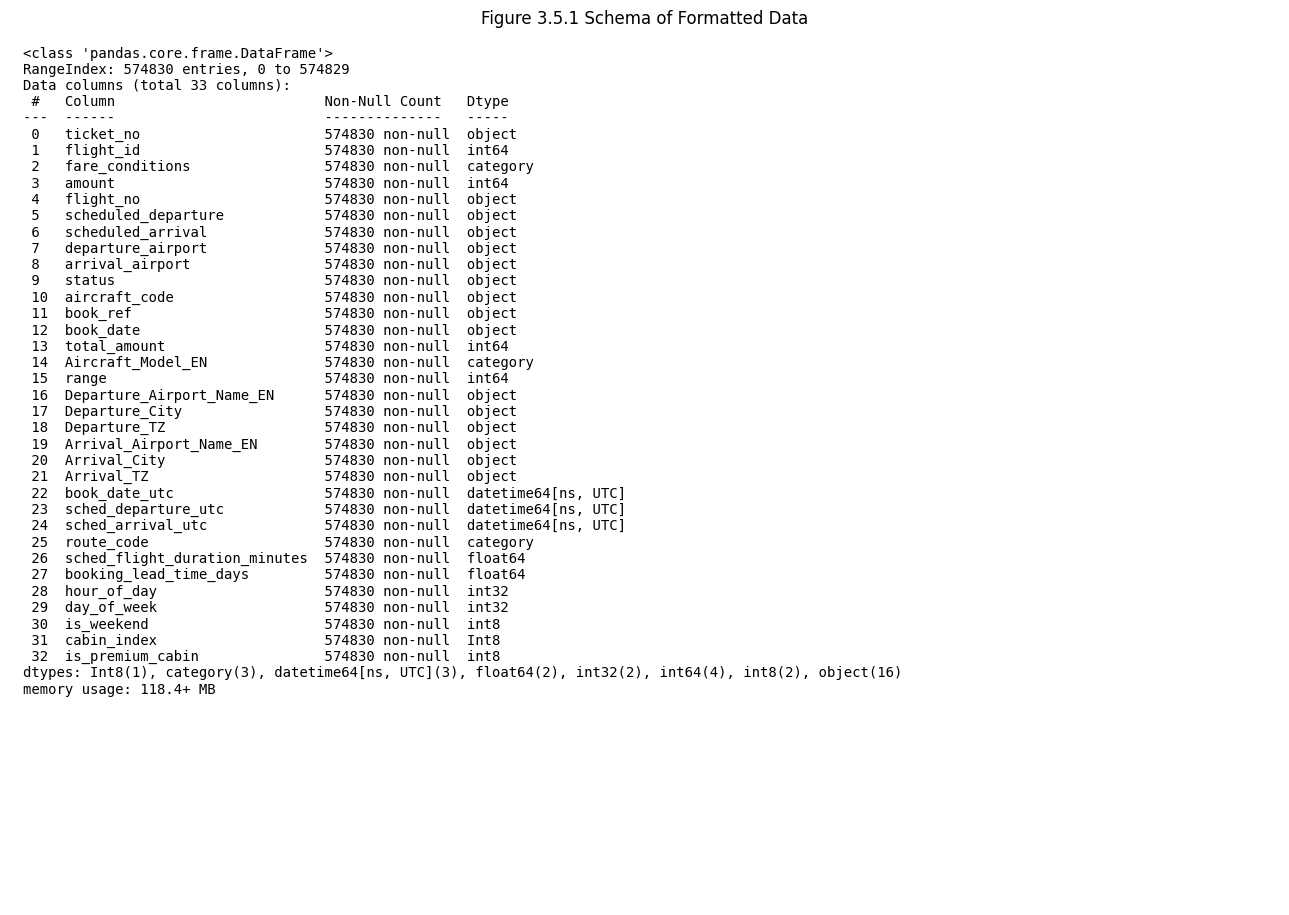

Saved FIGURE -> outputs/segment/figures/figure_3_5_1_schema.png
Saved CSV -> outputs/segment/tables/table_3_5_1_fare_counts.csv


fare_conditions,rows
Economy,506070
Business,58963
Comfort,9797



Report snippet:
- Target (y): amount. Chosen transform for Step 4.2 = log1p (ln(1+x)).
- Files saved under outputs/: master_formatted.parquet, X_features.parquet, y_target.parquet.
- Booking-level files: not required for current plan; segment-level is the analytical grain.
Saved -> X_features.parquet: (574830, 9)
Saved -> y_target_log.parquet  : (574830, 1) ['log1p_amount']


In [8]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

def to_utc(s):
    return pd.to_datetime(s, errors='coerce', utc=True)

def normalise_fare(x:str):
    if pd.isna(x): return pd.NA
    s = str(x).strip().title()
    mapping = {
        'Biz':'Business','B':'Business',
        'Premium Economy':'Comfort','Premium':'Comfort','Prem Eco':'Comfort',
        'Eco':'Economy','E':'Economy'
    }
    return mapping.get(s, s)  # 数据本身大多已是 Business/Comfort/Economy

def show_table(df: pd.DataFrame, title: str, csv_name: str):
    csv_path = TAB_DIR/csv_name
    df.to_csv(csv_path, index=False)
    print(f"Saved CSV -> {_rel(csv_path)}")
    try:
        sty = (df.style
               .set_table_styles([{'selector':'th','props':'font-weight:bold; text-align:center;'},
                                  {'selector':'td','props':'text-align:center;'}])
               .set_properties(**{'text-align':'center'}))
        # 兼容不同 pandas 版本
        if hasattr(sty, "hide_index"):
            sty = sty.hide_index()
        else:
            sty = sty.hide(axis="index")
        display(sty.set_caption(title))
    except Exception:
        print(title)
        display(df)

try:
    _ = final_df.shape
except NameError as e:
    raise RuntimeError("未检测到 final_df。请先运行 3.4 的整合代码以生成 final_df DataFrame。") from e

# 3.5.1 Normalize types & build light features (formatting only) / 3.5.1 规范类型 & 构建轻量特征（仅格式化所需）
df = final_df.copy()

# 统一时间为 UTC、并加强常用字段
df['book_date_utc']          = to_utc(df.get('book_date'))
df['sched_departure_utc']    = to_utc(df.get('scheduled_departure'))
df['sched_arrival_utc']      = to_utc(df.get('scheduled_arrival'))

# Route code (departure-arrival) / 路线编码（出发-到达）
df['route_code'] = (df['departure_airport'].astype(str) + '-' +
                    df['arrival_airport'].astype(str))

# Cabin normalization & categorization / 舱位归一化、类别化
df['fare_conditions'] = df['fare_conditions'].map(normalise_fare)
df['fare_conditions'] = pd.Categorical(df['fare_conditions'],
                                       categories=['Economy','Comfort','Business'],
                                       ordered=True)

# Compute scheduled flight duration (min) & booking lead time (days) / 计算计划飞行时长（分钟）与订票提前期（天）
df['sched_flight_duration_minutes'] = (
    (df['sched_arrival_utc'] - df['sched_departure_utc'])
    .dt.total_seconds()/60.0
)
df['booking_lead_time_days'] = (
    (df['sched_departure_utc'] - df['book_date_utc'])
    .dt.total_seconds()/(3600*24)
)

# 时间派生（用于后续 ColumnTransformer）
df['hour_of_day']  = df['sched_departure_utc'].dt.hour
df['day_of_week']  = df['sched_departure_utc'].dt.dayofweek  # Monday=0
df['is_weekend']   = df['day_of_week'].isin([5,6]).astype('int8')

# Cabin numeric index & premium flag / 舱位数值索引与是否高端舱
cabin_map = {'Economy':0, 'Comfort':1, 'Business':2}
df['cabin_index']      = df['fare_conditions'].map(cabin_map).astype('Int8')
df['is_premium_cabin'] = (df['cabin_index']>=1).astype('int8')

# 3.5.2 角色分离（y & X）并持久化
# —— 目标变量（y）：amount（segment-level ticket_flight amount）
y = df['amount'].astype('float64')

# —— 预测子集（X）：数值与分类型（供后续 ColumnTransformer）
X_num_cols = [
    'sched_flight_duration_minutes','booking_lead_time_days',
    'cabin_index','is_premium_cabin','hour_of_day','day_of_week'
]
X_cat_cols = [
    'fare_conditions','route_code','Aircraft_Model_EN'
]
# 确保类别 dtype
for c in X_cat_cols:
    df[c] = df[c].astype('category')

X = df[X_num_cols + X_cat_cols].copy()

# —— 输出到 Parquet（若无 pyarrow 自动 CSV 兜底）
def _save_parquet_or_csv(frame, path_parquet, path_csv):
    try:
        frame.to_parquet(path_parquet, index=False)
        print(f"Saved Parquet -> {_rel(path_parquet)}")
    except Exception as e:
        frame.to_csv(path_csv, index=False)
        print(f"[pyarrow/fastparquet 不可用，改存 CSV] -> {_rel(path_csv)}  ({e.__class__.__name__}: {e})")

_save_parquet_or_csv(df, OUT_DIR/"master_formatted.parquet", OUT_DIR/"master_formatted.csv")
_save_parquet_or_csv(X,  OUT_DIR/"X_features.parquet",      OUT_DIR/"X_features.csv")
_save_parquet_or_csv(y.to_frame('amount'),
                     OUT_DIR/"y_target.parquet",
                     OUT_DIR/"y_target.csv")

print("\nRoles → y shape:", y.shape, "| X shape:", X.shape)
print("Numeric predictors:", X_num_cols)
print("Categorical predictors:", X_cat_cols)

# 3.5.3 Figure 3.5.1 —— 架构截图（df.info）
buf = StringIO()
df.info(buf=buf)
schema_txt = buf.getvalue()

plt.figure(figsize=(13, min(10, 2 + 0.22*len(df.columns))))
plt.axis('off')
plt.text(0.01, 0.99, schema_txt, va='top', family='monospace')
plt.title("Figure 3.5.1 Schema of Formatted Data", pad=10)
plt.tight_layout()
fig_path = FIG_DIR/"figure_3_5_1_schema.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", _rel(fig_path))

# 3.5.4 Table 3.5.1 —— 舱位标签归一化结果
fare_tbl = (df['fare_conditions']
            .value_counts(dropna=False)
            .rename_axis('fare_conditions')
            .reset_index(name='rows'))
show_table(fare_tbl, "Table 3.5.1 — Label Normalisation for fare_conditions",
           "table_3_5_1_fare_counts.csv")

# 3.5.5 Report-ready confirmation sentence / 3.5.5 供报告粘贴的确认语句
TARGET_TRANSFORM = "log1p"   # 可选："log1p" 或 "yeo-johnson"
print("\nReport snippet:")
print(f"- Target (y): amount. Chosen transform for Step 4.2 = {TARGET_TRANSFORM} (ln(1+x)).")
print("- Files saved under outputs/: master_formatted.parquet, X_features.parquet, y_target.parquet.")
print("- Booking-level files: not required for current plan; segment-level is the analytical grain.")


import os, numpy as np, pandas as pd

assert 'X' in globals() and 'y' in globals(), "请先在上文生成 X 和 y 对象。"

y_s = pd.Series(y).astype(float)
# Optional: log1p transform for analysis only; saved separately to avoid overwriting y_target.parquet
if (y_s < 0).any():
    raise ValueError("y 含负数，无法进行 log1p。请确认 y 是否为 segment-level amount。")
y_log = np.log1p(y_s).rename("log1p_amount")

ART_DIR.mkdir(parents=True, exist_ok=True)

# Persist to disk / 落盘
pd.DataFrame(y_log).to_parquet(OUT_DIR/"y_target_log.parquet")
pd.DataFrame(X).to_parquet(OUT_DIR/"X_features.parquet")

print("Saved -> X_features.parquet:", pd.read_parquet(OUT_DIR/"X_features.parquet").shape)
print("Saved -> y_target_log.parquet  :", pd.read_parquet(OUT_DIR/"y_target_log.parquet").shape, list(pd.read_parquet(OUT_DIR/"y_target_log.parquet").columns))




In [9]:
import os, numpy as np, pandas as pd
from pandas.api.types import is_datetime64_any_dtype

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

X_path = find_path("X_features.parquet")
y_path = find_path("y_target.parquet")

X = pd.read_parquet(X_path)
y = pd.read_parquet(y_path).squeeze()
y.name = y.name or "y"

# 丢弃任何仍然是 datetime 的列；布尔→0/1（避免前面你遇到的 dtype 报错）
dt_cols = [c for c in X.columns if is_datetime64_any_dtype(X[c])]
if dt_cols:
    X = X.drop(columns=dt_cols)

for c in X.select_dtypes(include="bool").columns:
    X[c] = X[c].astype(int)

num_cols = list(X.select_dtypes(include=["number"]).columns)
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"X shape = {X.shape}; y shape = {y.shape}")
print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")


X shape = (574830, 9); y shape = (574830,)
Numeric cols: 6, Categorical cols: 3


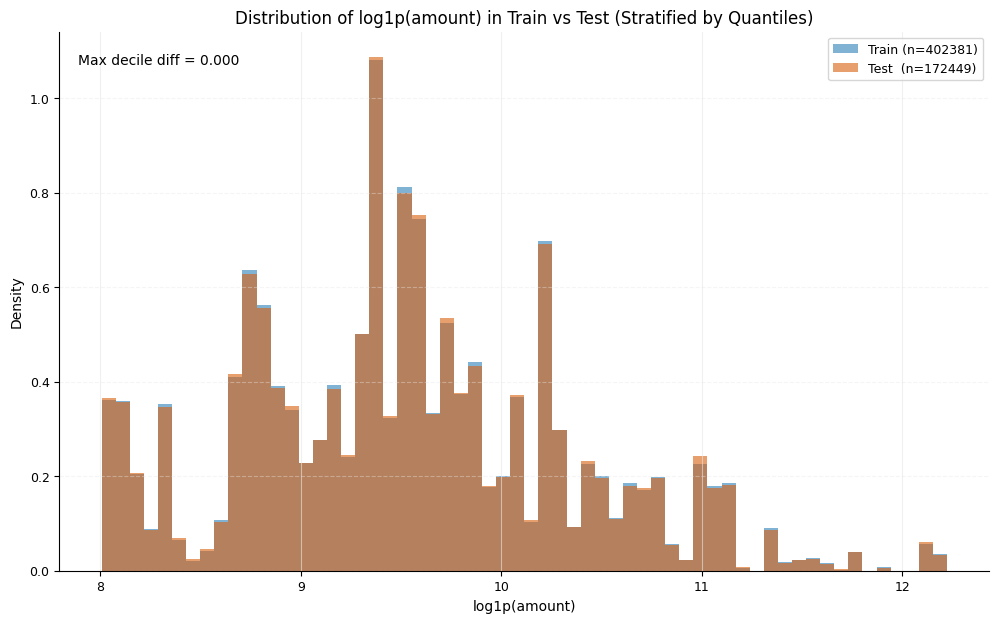

Saved figure -> outputs/segment/figures/Fig4_3_1_StratifiedSplit_TargetDist_v1.png and outputs/segment/figures/Fig4_3_1_StratifiedSplit_TargetDist_v1.svg
Indices saved -> outputs/segment/artifacts/train_index.csv and outputs/segment/artifacts/test_index.csv


In [10]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.30
Q = 10  # use deciles for stratification

# Load target / 加载目标变量
ydf = pd.read_parquet(OUT_DIR/"y_target.parquet")
assert "amount" in ydf.columns, "y_target.parquet must include amount"
y_raw = pd.to_numeric(ydf["amount"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
index_all = y_raw.index

# Stratify on log1p(amount) to reduce skewness
if (y_raw < 0).any():
    raise ValueError("amount contains negative values; cannot apply log1p.")
y = np.log1p(y_raw)

# Stratified split by quantiles (70/30) / 按分位分层切分（70/30）
bins = pd.qcut(y, q=Q, labels=False, duplicates="drop")
idx_train, idx_test = train_test_split(index_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=bins)
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Persist split indices / 持久化切分索引
ART_DIR.mkdir(parents=True, exist_ok=True)
pd.Series(idx_train, name="train_index").to_csv(ART_DIR/"train_index.csv", index=False)
pd.Series(idx_test,  name="test_index").to_csv(ART_DIR/"test_index.csv", index=False)

# Histogram overlay / 直方图叠加
def fd_bins(a):
    a = np.asarray(a)
    a = a[np.isfinite(a)]
    q75, q25 = np.percentile(a, [75, 25])
    iqr = q75 - q25
    n = len(a)
    if iqr == 0 or n <= 1:
        return 30
    h = 2 * iqr * (n ** (-1/3))
    return max(15, min(60, int(np.ceil((a.max() - a.min()) / h))))

bins_n = fd_bins(y)
hist_range = (min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max()))

plt.figure(figsize=(12,7))
plt.hist(y_train, bins=bins_n, range=hist_range, density=True, alpha=0.6, label=f"Train (n={len(y_train)})")
plt.hist(y_test,  bins=bins_n, range=hist_range, density=True, alpha=0.6, label=f"Test  (n={len(y_test)})")
plt.xlabel("log1p(amount)")
plt.ylabel("Density")
plt.title("Distribution of log1p(amount) in Train vs Test (Stratified by Quantiles)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()

# QC annotation: max decile diff / 质量标注：最大分位差
train_q = y_train.quantile(np.linspace(0, 1, 11))
test_q = y_test.quantile(np.linspace(0, 1, 11))
max_abs = (train_q - test_q).abs().max()
plt.text(0.02, 0.96, f"Max decile diff = {max_abs:.3f}", transform=plt.gca().transAxes, va="top")

# Save figures / 保存图表
FIG_DIR.mkdir(parents=True, exist_ok=True)
base = FIG_DIR/"Fig4_3_1_StratifiedSplit_TargetDist_v1"
plt.savefig(base.with_suffix(".png"), dpi=300, bbox_inches="tight")
plt.savefig(base.with_suffix(".svg"), bbox_inches="tight")
plt.show()

print("Saved figure ->", _rel(base.with_suffix(".png")), "and", _rel(base.with_suffix(".svg")))
print("Indices saved ->", _rel(ART_DIR/"train_index.csv"), "and", _rel(ART_DIR/"test_index.csv"))
